<a href="https://colab.research.google.com/github/akshaygopalkr/EM-VLM4AD/blob/main/drivelm_mf_train_T5_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Importing/Installation

In [ ]:
!pip install peft
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 11.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from transformers import T5Tokenizer
from torchvision import transforms
import torch
import json
import os
import time
from transformers import T5ForConditionalGeneration, TrainingArguments, Trainer, GPT2LMHeadModel, GPT2TokenizerFast
from torchvision.models import vit_b_32
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import argparse
from peft import LoraConfig, get_peft_model
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from tqdm import tqdm


## Model Code

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEXT_MAX_LENGTH = 463
VIT_HIDDEN_STATE = 768
VIT_SEQ_LENGTH = 49
GPT_N_EMBED = 1024

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    print(
        f"Trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )



class DriveVLM(nn.Module):

    def __init__(self, config):

        super().__init__()

        # Make tokenizer and text model
        if config.lm == 'T5':
            self.model = T5ForConditionalGeneration.from_pretrained('google-t5/t5-base')
            hidden_size = self.model.config.d_model
        else:
            self.model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
            hidden_size = GPT_N_EMBED


        # Only if we are perfoming LoRA finetuning on T5
        if config.lora:

            if config.lm == 'T5':
              tm = ['q', 'v']
            else:
              tm = ['c_attn']

            # Create LoRA model
            lora_config = LoraConfig(
                r=config.lora_dim,
                lora_alpha=config.lora_alpha,
                lora_dropout=config.lora_dropout,
                bias='none',
                target_modules=tm
            )
            self.model = get_peft_model(self.model, lora_config)

        # Freeze model weights if needed
        if config.freeze_lm:

            for param in self.model.parameters():
                param.requires_grad = False

        print('Trainable Parameters for LM model:')
        print_trainable_parameters(self.model)

        # Create instance for multi-view processor
        self.mvp = self.MultiViewProcessor(config.gpa_hidden_size, hidden_size, config.lm, freeze=True)

    class MultiViewProcessor(nn.Module):

        def __init__(self, gpa_hidden_size, hidden_size, lm, freeze=False):

            super().__init__()

            # Use ViT for image embeddings
            self.img_model = vit_b_32(weights='DEFAULT')
            self.lm = lm

            # Modal embedding to distinguish between image and text
            self.modal_embeddings = nn.Embedding(2, hidden_size)
            self.modal_embeddings.weight.data.normal_(mean=0.0, std=0.02)

            # If we are freezing the CLIP embeddings
            if freeze:
                for param in self.img_model.parameters():
                    param.requires_grad = False

            # Set matrices based on MIVC paper
            self.w = nn.Linear(in_features=gpa_hidden_size, out_features=1)
            self.Z = nn.Sequential(
                nn.Linear(in_features=VIT_HIDDEN_STATE * VIT_SEQ_LENGTH, out_features=gpa_hidden_size, bias=False),
                nn.Tanh()
            )
            self.G = nn.Sequential(
                nn.Linear(in_features=VIT_HIDDEN_STATE * VIT_SEQ_LENGTH, out_features=gpa_hidden_size, bias=False),
                nn.Sigmoid()
            )

            if self.lm != 'T5':
              self.img_projection_layer = nn.Linear(in_features=VIT_HIDDEN_STATE, out_features=hidden_size)


        def gpa(self, img_embeddings):

            """"
            Calculates the gated-pooling attention score for the image embeddings
            :param img_embeddings: (6x768) dimensional
            :return single embedding of size (768,)
            """

            # Get weights for gated pooling attention
            gpa_weights = torch.softmax(self.w(self.Z(img_embeddings) * self.G(img_embeddings)), dim=0  )

            # Take a linear combination of all the image embeddings
            fused_embeddings = torch.sum(gpa_weights * img_embeddings, dim=0)

            return fused_embeddings

        def get_img_embedding(self, imgs):

            N = imgs.shape[0]

            # Process into patches (N x 6 x 49 x H)
            merged_embedding = torch.stack([self.img_model._process_input(img) for img in imgs], dim=0)

            # Concatenate the batch class tokens -> (N, 6, 50, H)
            batch_class_tokens = self.img_model.class_token.expand(merged_embedding.shape[1], -1, -1).repeat(N, 1, 1, 1)
            merged_embedding = torch.cat([batch_class_tokens, merged_embedding], dim=2)

            # Add positional embeddings and remove class token -> (N, 6, 49, H)
            merged_embedding += self.img_model.encoder.pos_embedding.repeat(N, 1, 1, 1)
            merged_embedding = merged_embedding[:, :, 1:]

            # Get merged embedding and reshape to 2D embedding -> (N, 1, 49, H)
            merged_embedding = torch.stack([self.gpa(embedding.flatten(start_dim=1)).reshape(VIT_SEQ_LENGTH,
                                            VIT_HIDDEN_STATE) for embedding in merged_embedding], dim=0)

            # Project to VL dimension -> (1, 49, H) (H is 512 for t5-small, 768 for t5-base)
            if self.lm != 'T5':
              merged_embedding = self.img_projection_layer(merged_embedding)

            # Add modal type embedding to merged embedding
            merged_embedding += self.modal_embeddings(
                torch.ones((1, merged_embedding.shape[1]), dtype=torch.int, device=device))

            return merged_embedding

        def forward(self, text_enc, imgs, text_model):

            # Get the image embeddings (N x 1 x 49 x H)
            imgs_embedding = self.get_img_embedding(imgs)

            # Get the text embeddings (N x S x H)
            text_embeddings = text_model.get_input_embeddings()(text_enc)

            # Add modal embeddings to text
            text_embeddings += self.modal_embeddings(torch.zeros((1, text_embeddings.shape[1]), dtype=torch.int,
                                                                 device=device))

            # Concatenate embeddings -> (1 x S x 512)
            merged_embedding = torch.cat([text_embeddings, imgs_embedding], dim=1)

            return merged_embedding

    def forward(self, text_enc, imgs, labels=None):

        # Get the merged embeddings
        merged_embedding = self.mvp(text_enc, imgs, self.model)

        # If training include the labels
        return self.model(inputs_embeds=merged_embedding, labels=labels)


## Dataset Code

In [ ]:
class MultiFrameDataset(Dataset):

    def __init__(self, input_file, tokenizer, transform=None):
        with open(input_file) as f:
            self.data = json.load(f)

        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the question and answer at the idx
        qa, img_path = self.data[idx]
        img_path = [os.path.join('DriveLM', p)
                    for p in list(img_path.values())]

        q_text, a_text = qa['Q'], qa['A']
        q_text = f"Question: {q_text} Answer:"

        # Concatenate images into a single tensor
        imgs = [self.transform(read_image(p).float()).to(device) for p in img_path]
        imgs = torch.stack(imgs, dim=0)

        return q_text, imgs, a_text

    def collate_fn(self, batch):

        q_texts, imgs, a_texts = zip(*batch)
        imgs = torch.stack(list(imgs), dim=0)

        encodings = self.tokenizer(q_texts, padding=True, return_tensors="pt").input_ids.to(device)
        labels = self.tokenizer(a_texts, padding=True, return_tensors='pt').input_ids.to(device)

        return encodings, imgs, labels

## Downloading Data

In [ ]:
!mkdir DriveLM
!mkdir DriveLM/results
!unzip -q drive/MyDrive/DriveLM/data.zip -d DriveLM

## Hyperparameters

In [ ]:
Config = namedtuple('Instance', ['batch_size', 'learning_rate',
                                 'weight_decay', 'num_workers',
                                 'epochs', 'custom_train', 'gpa_hidden_size',
                                 'lora', 'lora_dim', 'lora_alpha', 'lora_dropout',
                                 'load_checkpoint', 'file_checkpoint', 'checkpoint_frequency',
                                 'freeze_lm', 'lm'])

config = Config(
    batch_size = 4,
    learning_rate = 1e-4,
    weight_decay = 0.05,
    num_workers = 0,
    epochs = 6,
    custom_train = True,
    gpa_hidden_size = 128,
    lora = False,
    lora_dim = 64,
    lora_alpha = 32,
    lora_dropout = 0.05,
    load_checkpoint = True,
    file_checkpoint = '20240301-053312',
    checkpoint_frequency = 15000,
    freeze_lm = True,
    lm = 'T5'
)

## Training Code

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Trainable Parameters for LM model:
Trainable params: 0 || all params: 222903552 || trainable%: 0.0


Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:02<00:00, 139MB/s]


Trainable Parameters for full model
Trainable params: 9635457 || all params: 320763241 || trainable%: 3.0039155889436846


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:246: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on google-t5/t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want 

Loading model from 20240301-053312
Trainable Parameters for LM model:
Trainable params: 0 || all params: 222903552 || trainable%: 0.0
Minimum Training Loss: 2.7975868663738566
Training Losses: [3.660469481681494, 2.909258536649628, 2.8441037475382545, 2.7975868663738566]
Minimum Validation Loss: 2.0941378722678587
Validation Losses: [2.218905387405244, 2.1350354600343073, 2.0941378722678587, 2.0981687722072135]
Epochs ran: 4
-------------------- EPOCH 4 ---------------------


  0%|          | 0/85346 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Loss: 4.092721462249756

Questions:
['Question: Which lanes are each important object on in the scene? Answer:', 'Question: Would < c2,CAM_FRONT_LEFT,691.5,351.6> be in the moving direction of the ego vehicle? Answer:', 'Question: What is the relative positioning of the important objects in the current scene? Answer:', 'Question: What is the probability of colliding with < c2,CAM_BACK,587.5,505.0> after the ego vehicle goes straight and keeps the same speed? Answer:']

Generated Answers:
['.-.-0.. 00-0...  the processa.a.', 'No', '-lum0.0IRTOUR..01,.. notsensitive of the.-=0-AACK.0-.00..', '-']

Ground Truth Answers:
['< c2,CAM_BACK,980.1,642.6> is in the ego lane.', 'No.', '< c2,CAM_FRONT,1360.0,543.3> is in front of < c1,CAM_BACK,196.2,695.0>.', 'Low.']


 18%|█▊        | 15000/85346 [1:37:47<9:00:59,  2.17it/s]


Loss: 2.102548122406006

Questions:
['Question: Identify all the traffic elements in the front view, categorize them, determine their status, and predict the bounding box around each one. The output should be a list formatted as (c, s, x1, y1, x2, y2), where c represents the category, s denotes the status, and x1, y1, x2, y2 are the offsets of the top-left and bottom-right corners of the box relative to the center point. Answer:', 'Question: What is the visual description of < c2,CAM_BACK_LEFT,560.0,646.7>? Answer:', 'Question: What actions taken by the ego vehicle can lead to a collision with < c2,CAM_FRONT_RIGHT,575.8,600.0>? Answer:', 'Question: What is the status of the cars that are to the back of the ego car? Answer:']

Generated Answers:
['is no more element in the front view. data should the column element is notsc)) ]) th] x.28] 620.. 8.1.64]].', 'and is', '.. be to a collision.e', 'people are ina in A']

Ground Truth Answers:
['There is one traffic element in the front view.

 35%|███▌      | 30001/85346 [3:09:27<6:32:41,  2.35it/s]


Loss: 2.66945743560791

Questions:
['Question: What are objects to the front left of the ego car? Answer:', 'Question: Is < c3,CAM_FRONT,715.0,473.3> an object that the ego vehicle should consider in the current scene? Answer:', 'Question: What is the priority of the objects that the ego vehicle should consider?(in descending order) Answer:', 'Question: What is the status of the cars that are to the back of the ego car? Answer:']

Generated Answers:
['is no-s two carss. and pedestrian, and one passenger. the left left. the ego car. A', '.  A A', '-0-01.T_, km03.2.2.0.-1,0-FRONT.0.000.00..22 c-0-Frow,020.002.0,', 'people are in to']

Ground Truth Answers:
['There are one motorcycle, many pedestrians, one truck, and one trailer to the front left of the ego car.', 'No.', '< c1,CAM_FRONT,92.5,451.7>, < c2,CAM_FRONT,1152.5,510.8>, < c3,CAM_BACK,670.8,544.2>.', 'Many cars are moving.']


 53%|█████▎    | 45001/85346 [4:40:32<4:18:48,  2.60it/s]


Loss: 2.817328453063965

Questions:
['Question: What is the moving status of object < c1,CAM_BACK,1080.0,515.8>? Answer:', 'Question: Predict the behavior of the ego vehicle. Answer:', 'Question: Please describe the current scene. Answer:', 'Question: Are there standing pedestrians to the front left of the ego car? Answer:']

Generated Answers:
['to,', 'a vehicle is  to. ego is is going.', "is two ways' cars in the of the stationER. park there is....", ',']

Ground Truth Answers:
['Going ahead.', 'The ego vehicle is going straight. The ego vehicle is not moving.', 'There are two parked cars in front of the ego car and one moving bus behind it.', 'Yes.']


 70%|███████   | 60001/85346 [6:10:36<2:26:42,  2.88it/s]


Loss: 2.9325618743896484

Questions:
['Question: What is the observed status of object < c1,CAM_FRONT,829.9,491.7>? Answer:', 'Question: What is the future state of < c1,CAM_FRONT,1079.2,586.7>? Answer:', 'Question: Are there parked construction vehicles to the front right of the ego car? Answer:', 'Question: What is the status of the truck that is to the front of the ego car? Answer:']

Generated Answers:
['to,', 'er. to', ',', '- is a in']

Ground Truth Answers:
['Moving.', 'Keep going straight.', 'No.', 'One truck is parked.']


 88%|████████▊ | 75001/85346 [7:40:22<1:00:45,  2.84it/s]


Loss: 1.7227442264556885

Questions:
['Question: Is there any traffic element in the front view? Answer:', 'Question: What is the status of the trailer that is to the back left of the ego car? Answer:', 'Question: Would < c4,CAM_BACK,260.0,667.4> be in the moving direction of the ego vehicle? Answer:', 'Question: Are there moving cars to the back of the ego car? Answer:']

Generated Answers:
[", no' no rules elements in the front view.", '- is.', ',', ',']

Ground Truth Answers:
['Yes, there are some traffic elements in the front view.', 'One trailer is moving.', 'No.', 'Yes.']


100%|██████████| 4947/4947 [28:18<00:00,  2.91it/s]


Training Loss: 2.796209863463718
Validation Loss: 2.133269168245255
---------------------------------------------
-------------------- EPOCH 5 ---------------------


  0%|          | 1/85346 [00:00<10:45:37,  2.20it/s]


Loss: 4.776639938354492

Questions:
['Question: What is the observed status of object < c1,CAM_FRONT_RIGHT,557.5,529.2>? Answer:', 'Question: Is < c4,CAM_FRONT_RIGHT,457.5,651.4> an object that the ego vehicle should consider in the current scene? Answer:', 'Question: What is the moving status of object < c1,CAM_BACK,1024.2,475.0>? Answer:', 'Question: Would < c1,CAM_FRONT,726.7,452.5> be in the moving direction of the ego vehicle? Answer:']

Generated Answers:
['to', ',', 'to is', ',']

Ground Truth Answers:
['Moving.', 'Yes.', 'Going ahead.', 'Yes.']


 18%|█▊        | 15001/85346 [1:36:54<7:20:11,  2.66it/s]


Loss: 2.2547249794006348

Questions:
['Question: Are < c3,CAM_FRONT,1461.7,517.5> and < c2,CAM_BACK,850.7,495.0> traffic signs? Answer:', 'Question: What actions taken by the ego vehicle can lead to a collision with < c3,CAM_FRONT,449.2,483.3>? Answer:', 'Question: Are < c5,CAM_FRONT,650.5,369.0> and < c3,CAM_BACK,855.0,536.7> traffic signs? Answer:', 'Question: What are objects to the front right of the ego car? Answer:']

Generated Answers:
['-  thisa signal. A.', '... the ego vehicle. lead to a collision with a3,CAM_FRONT,49.2,483.3??', 'minute the is a sign.', 'is no in but train, and one bus. the left right of the carego car.']

Ground Truth Answers:
['Neither is a traffic sign.', 'No action taken by the ego vehicle will lead to a collision with < c3,CAM_FRONT,449.2,483.3>.', 'Only one of the boxes is a traffic sign.', 'There is one car, one barrier, and one truck to the front right of the ego car.']


 35%|███▌      | 30001/85346 [3:09:58<5:24:45,  2.84it/s]


Loss: 5.012705326080322

Questions:
['Question: What object would consider < c3,CAM_FRONT,879.2,495.8> to be most relevant to its decision? Answer:', 'Question: What is the visual description of < c2,CAM_FRONT,125.0,615.0>? Answer:', 'Question: What is the future state of < c3,CAM_FRONT_RIGHT,254.4,606.7>? Answer:', 'Question: Are there parked trailers to the front of the ego car? Answer:']

Generated Answers:
['a of is', 'is..', 'ary bus', ',']

Ground Truth Answers:
['The ego vehicle.', 'Orange clothes pedestrian.', 'Stationary.', 'Yes.']


 53%|█████▎    | 45001/85346 [4:41:47<4:21:04,  2.58it/s]


Loss: 2.585052013397217

Questions:
['Question: Which object is most likely to be occluded by < c3,CAM_BACK,915.8,515.8>? Would this object affect the ego vehicle? Based on this object, what action of the ego vehicle is dangerous? Answer:', 'Question: Would < c4,CAM_FRONT_RIGHT,553.8,473.4> be in the moving direction of the ego vehicle? Answer:', 'Question: What is the observed status of object < c2,CAM_FRONT_LEFT,869.2,533.3>? Answer:', 'Question: What actions taken by the ego vehicle can lead to a collision with < c4,CAM_BACK,1057.5,511.8>? Answer:']

Generated Answers:
['.. no.', 'parking', 'bus', 'stricting  the left.']

Ground Truth Answers:
['None, no, none.', 'No.', 'Stationary.', 'Reversing to the left.']


 70%|███████   | 60001/85346 [6:15:30<2:36:33,  2.70it/s]


Loss: 1.6218993663787842

Questions:
['Question: Are there parked cars to the back right of the ego car? Answer:', 'Question: What are objects to the back right of the ego car? Answer:', 'Question: What is the status of the trailer that is to the front of the ego car? Answer:', 'Question: Is < c5,CAM_FRONT,1178.3,444.2> a traffic sign or a road barrier? Answer:']

Generated Answers:
['.', 'is no the back right of the ego car.', 'is the of the ego car. not..', ', is']

Ground Truth Answers:
['Yes.', 'There is one car to the back right of the ego car.', 'The trailer in front of the ego car is moving.', 'No.']


 88%|████████▊ | 75001/85346 [7:50:31<1:03:38,  2.71it/s]


Loss: 2.3401918411254883

Questions:
['Question: Will < c3,CAM_FRONT,979.6,435.1> be in the moving direction of < c1,CAM_BACK,866.7,532.5>? Answer:', 'Question: What are objects to the back of the ego car? Answer:', 'Question: What are objects to the front left of the ego car? Answer:', 'Question: Are there parked cars to the front of the ego car? Answer:']

Generated Answers:
['.. No', 'is  way stop no buses, and one bus. the ego car.', 'is no directions in  passenger. the front of of the ego car.', ',. No']

Ground Truth Answers:
['No.', 'There is one bus, three cars, and one pedestrian behind the ego car.', 'There are two cars and one pedestrian to the front left of the ego car.', 'Yes.']


100%|██████████| 4947/4947 [27:52<00:00,  2.96it/s]


Training Loss: 2.771425576585811
Validation Loss: 2.094110767070708
---------------------------------------------
Trainable Parameters for LM model:
Trainable params: 0 || all params: 222903552 || trainable%: 0.0


100%|██████████| 4205/4205 [23:41<00:00,  2.96it/s]


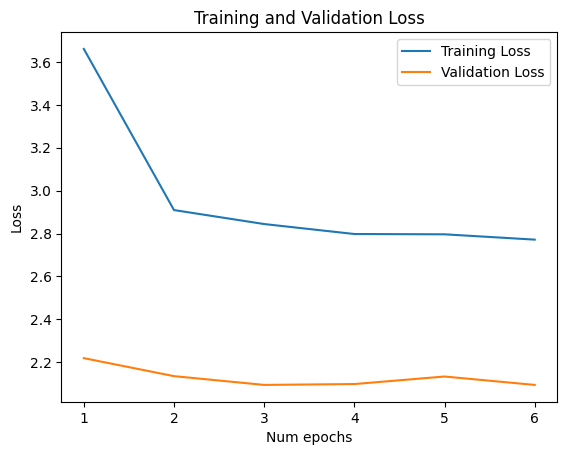

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def save_model(model, model_name):
    # Save the model into the designated folder
    path = os.path.join('drive', 'MyDrive', 'DriveLM', 'multi_frame_results', timestr, model_name + '.pth')
    torch.save(model, path)


def val_model(dloader, val_model):
    val_model.eval()
    val_loss = 0

    for idx, (inputs, imgs, labels) in tqdm(enumerate(dloader), total=len(dloader)):
        outputs = val_model(inputs, imgs, labels)
        val_loss += outputs.loss.item()

    return val_loss / len(val_dataloader)


def save_stats(train_loss, val_loss, epochs, lr):
    stats_dict = {
        'losses': losses,
        'val losses': val_losses,
        'min train loss': train_loss,
        'min val loss': val_loss,
        'epochs': epochs,
        'learning rate': lr,
        'LM': 'T5-Base',
        'Image Embedding': 'Patch'
    }

    # Save stats into checkpoint
    with open(os.path.join('drive', 'MyDrive', 'DriveLM', 'multi_frame_results', timestr, 'stats.json'), 'w') as f:
        json.dump(stats_dict, f)


def plot_loss(training_loss, val_loss):
    num_epochs = len(training_loss)

    plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Num epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('drive', 'MyDrive', 'DriveLM', 'multi_frame_results', timestr, 'loss.png'))


def custom_train(train_loss, val_loss, best_model, epochs, learning_rate):

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

    for epoch in range(epochs, config.epochs):
        print('-------------------- EPOCH ' + str(epoch) + ' ---------------------')
        model.train()
        epoch_loss = 0

        for step, (inputs, imgs, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

            # print(inputs.shape, imgs.shape, labels.shape)

            # Forward pass through model
            outputs = model(inputs, imgs, labels)

            # Calculate loss
            loss = outputs.loss
            epoch_loss += loss.item()

            if step % config.checkpoint_frequency == 0:
              print()
              print('Loss: ' + str(loss.item()))

              # Get the hidden states (output)
              hidden_states = outputs.logits

              # Perform decoding (e.g., greedy decoding)
              outputs = torch.argmax(hidden_states, dim=-1)

              text_outputs = [processor.decode(output.to('cpu'), skip_special_tokens=True) for output in outputs]
              text_questions = [processor.decode(q.to('cpu'), skip_special_tokens=True) for q in inputs]
              text_labels = [processor.decode(a.to('cpu'), skip_special_tokens=True) for a in labels]
              print()
              print('Questions:')
              print(text_questions)
              print()
              print('Generated Answers:')
              print(text_outputs)
              print()
              print('Ground Truth Answers:')
              print(text_labels)

            # Back-propogate
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Get train and val loss per batch
        epoch_train_loss = epoch_loss / len(train_dataloader)
        losses.append(epoch_train_loss)

        epoch_val_loss = val_model(val_dataloader, model)
        val_losses.append(epoch_val_loss)

        if not val_loss or min(epoch_val_loss, val_loss) == epoch_val_loss:
            val_loss = epoch_val_loss
            best_model = deepcopy(model.state_dict())
        if not train_loss or min(train_loss, epoch_train_loss) == epoch_train_loss:
            train_loss = epoch_train_loss

        # Adjust learning rate scheduler
        scheduler.step()

        print('Training Loss: ' + str(epoch_train_loss))
        print('Validation Loss: ' + str(epoch_val_loss))
        print('---------------------------------------------')

        # Save model and stats for checkpoints
        save_model(best_model, 'latest_model')
        epochs += 1
        save_stats(train_loss, val_loss, epochs, scheduler.get_last_lr()[0])

    # Save the model and plot the loss
    plot_loss(losses, val_losses)
    return train_loss, val_loss


def train():
    training_config = TrainingArguments(
        output_dir="agopalkr/EfficientDriveLM",
        learning_rate=config.learning_rate,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=config.batch_size,
        num_train_epochs=config.epochs,
        weight_decay=config.weight_decay,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        config=training_config,
        train_dataset=train_dset,
        eval_dataset=val_dset,
    )

    trainer.train()
    model.push_to_hub("agopalkr/EfficientDriveLM")


def save_experiment(statistics):
    """
    Saves the experiment multi_frame_results to a csv
    :param config: The hyperparameters used
    :param statistics: The accuracies for the training, validation, and test sets
    """
    trial_dict = {
        'Model name': [timestr],
        'Learning rate': [config.learning_rate],
        'Weight decay': [config.weight_decay],
        'Batch size': [config.batch_size],
        'Epochs': [config.epochs],
        'LoRA finetuning': [config.lora],
        'GPA Hidden Size': [config.gpa_hidden_size],
        'LoRA Dimension': [config.lora_dim],
        'LoRA Alpha': [config.lora_alpha],
        'LoRA Dropout': [config.lora_dropout],
        'Freeze T5': [config.freeze_lm],
        'Min Training Loss': [statistics[0]],
        'Min Validation Loss': [statistics[1]],
        'Min Testing Loss': [statistics[2]],
    }

    trial_dict = pd.DataFrame(trial_dict)
    trial_dict.to_csv(os.path.join('drive', 'MyDrive', 'DriveLM', 'multi_frame_results', timestr, 'multi_frame_results.csv'), index=False, header=True)


if __name__ == '__main__':

    timestr = time.strftime("%Y%m%d-%H%M%S")

    losses = []
    val_losses = []
    min_train_loss = None
    min_val_loss = None
    best_model = None
    epochs_ran = 0

    # Load processors and models
    model = DriveVLM(config)
    model.to(device)
    print('Trainable Parameters for full model')
    print_trainable_parameters(model)

    if config.lm == 'T5':
      processor = T5Tokenizer.from_pretrained('google-t5/t5-base')
      processor.add_tokens('<')
    else:
      processor = GPT2TokenizerFast.from_pretrained('gpt2-medium')
      processor.pad_token = processor.eos_token

    train_dset = MultiFrameDataset(
        input_file=os.path.join('DriveLM', 'data', 'multi_frame',
                                'multi_frame_train.json'),
        tokenizer = processor,
        transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5))
        ])
    )
    val_dset = MultiFrameDataset(
        input_file=os.path.join('DriveLM', 'data', 'multi_frame',
                                'multi_frame_val.json'),
        tokenizer = processor,
        transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5))
        ])
    )
    test_dset = MultiFrameDataset(
        input_file=os.path.join('DriveLM', 'data', 'multi_frame',
                                'multi_frame_test.json'),
        tokenizer = processor,
        transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5))
        ])
    )

    # Create Dataloaders
    train_dataloader = DataLoader(train_dset, shuffle=True, batch_size=config.batch_size,
                                  num_workers=config.num_workers, collate_fn=train_dset.collate_fn)
    val_dataloader = DataLoader(val_dset, shuffle=True, batch_size=config.batch_size,
                                num_workers=config.num_workers, collate_fn=train_dset.collate_fn)
    test_dataloader = DataLoader(test_dset, shuffle=True, batch_size=config.batch_size,
                                 num_workers=config.num_workers, collate_fn=train_dset.collate_fn)

    if config.custom_train:

        # Load checkpoint if neccesary:
        if config.load_checkpoint:

            print('Loading model from ' + config.file_checkpoint)

            # Load the model and stats from the checkpoint
            model.load_state_dict(torch.load(os.path.join('drive', 'MyDrive', 'DriveLM', 'multi_frame_results', config.file_checkpoint,
                                                          'latest_model.pth')))
            best_model = DriveVLM(config)
            best_model.load_state_dict(torch.load(os.path.join('drive', 'MyDrive', 'DriveLM', 'multi_frame_results', config.file_checkpoint,
                                                               'latest_model.pth')))

            with open(os.path.join('drive', 'MyDrive', 'DriveLM', 'multi_frame_results', config.file_checkpoint, 'stats.json'), 'r') as f:
                stats = json.load(f)

            min_train_loss, min_val_loss, losses, val_losses, epochs_ran = stats['min train loss'], stats['min val loss'], stats['losses'], stats['val losses'], stats['epochs']

            # Just to correct previous mistake
            # val_losses[:2] = [val_loss*len(val_dataloader_4) for val_loss in val_losses[:2]]
            # val_losses[2:] = [val_loss*len(val_dataloader_2) for val_loss in val_losses[2:]]
            # min_val_loss *= len(val_dataloader_2)

            print(f'Minimum Training Loss: {min_train_loss}')
            print(f'Training Losses: {losses}')
            print(f'Minimum Validation Loss: {min_val_loss}')
            print(f'Validation Losses: {val_losses}')
            print(f'Epochs ran: {epochs_ran}')
            timestr = config.file_checkpoint
        else:
            os.mkdir(os.path.join('drive', 'MyDrive', 'DriveLM', 'multi_frame_results', timestr))

        if config.load_checkpoint:
          lr = stats['learning rate']
        else:
          lr = config.learning_rate

        min_train_loss, min_val_loss = custom_train(min_train_loss, min_val_loss, best_model, epochs_ran, lr)
        best_model = DriveVLM(config)
        best_model.load_state_dict(torch.load(os.path.join('drive', 'MyDrive', 'DriveLM', 'multi_frame_results', timestr, 'latest_model.pth')))
        best_model.to(device)
        test_loss = val_model(test_dataloader, best_model)
        statistics = [min_train_loss, min_val_loss, test_loss]
        save_experiment(statistics)
    else:
        train()


In [ ]:
from google.colab import runtime
runtime.unassign()